# ECE176 Final Project

In [12]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt

## Dataset

In [3]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(device)
    gpu_capability = torch.cuda.get_device_capability(device)
    total_memory = torch.cuda.get_device_properties(device).total_memory / 1e9  # Convert to GB

    print(f"GPU Name: {gpu_name}")
    print(f"Compute Capability: {gpu_capability}")
    print(f"Total Memory: {total_memory:.2f} GB")
else:
    print("CUDA device not available.")


GPU Name: NVIDIA GeForce RTX 2070
Compute Capability: (7, 5)
Total Memory: 8.36 GB


In [38]:
# %% [code]
print("hi")
import mido
from mido import MidiFile, tick2second
from tqdm import tqdm
import json

# Load the pre-built vocabulary
vocab_path = "datasets/vocab/vocab.json"
print("Loading vocabulary from:", vocab_path)
with open(vocab_path, "r") as f:
    vocab = json.load(f)
print("Vocabulary loaded with size:", len(vocab))

# Path to the MIDI file to tokenize
midi_file_path = "016c515bc5a8139fbd1bb599bc7d9c0c.mid"
print("\nLoading MIDI file:", midi_file_path)
mid = MidiFile(midi_file_path)
print("MIDI file loaded.")
print("Ticks per beat:", mid.ticks_per_beat)

# Default tempo (if no tempo message is encountered)
current_tempo = 500000  # in microseconds per beat (default 120 BPM)

# List to hold the token sequence
token_sequence = []

print("\nStarting tokenization process...")

# Since this is a Type 0 (single-track) MIDI file, we work with the first (and only) track.
track = mid.tracks[0]
print("Processing track with", len(track), "messages...\n")

# Iterate over each message in the track with a progress bar.
for msg in tqdm(track, desc="Processing messages", unit="msg"):
    # Check for tempo changes
    if msg.type == 'set_tempo':
        current_tempo = msg.tempo
        print(f"Tempo change detected. New tempo: {current_tempo} µs/beat")
        continue

    # --- Time shift tokens ---
    # Every message has a delta-time (in ticks). Convert this to milliseconds.
    if msg.time > 0:
        # Convert ticks to seconds using the current tempo and ticks_per_beat
        delta_seconds = tick2second(msg.time, mid.ticks_per_beat, current_tempo)
        delta_ms = int(round(delta_seconds * 1000))
        # Because our TIME_SHIFT tokens only come in 10ms increments (min 10ms, max 1000ms),
        # we need to break the delta time into one or more TIME_SHIFT tokens.
        while delta_ms > 0:
            # If delta_ms is less than 10, we still output a 10ms token (our resolution is 10ms)
            if delta_ms < 10:
                shift = 10
            else:
                # Use multiples of 10 up to 1000ms
                shift = min(1000, (delta_ms // 10) * 10)
                if shift == 0:
                    shift = 10
            token = f"TIME_SHIFT_{shift}ms"
            token_sequence.append(token)
            delta_ms -= shift

    # --- MIDI event tokens ---
    # We care about note events here. (Other events are ignored.)
    if msg.type == 'note_on':
        # A note_on with velocity 0 is treated as note_off.
        if msg.velocity == 0:
            token = f"NOTE_OFF_{msg.note}"
            token_sequence.append(token)
        else:
            # According to the Music Transformer scheme, a velocity token comes before the note_on.
            # Quantize velocity from 1-127 to 1-32.
            quantized_velocity = int(round((msg.velocity - 1) / 126 * 31)) + 1
            velocity_token = f"VELOCITY_{quantized_velocity}"
            token_sequence.append(velocity_token)
            # Add the note_on token.
            note_on_token = f"NOTE_ON_{msg.note}"
            token_sequence.append(note_on_token)
    elif msg.type == 'note_off':
        token = f"NOTE_OFF_{msg.note}"
        token_sequence.append(token)
    # Other message types (e.g., control_change) are not tokenized for this purpose.

print("\nTokenization complete!")
print("Total tokens generated:", len(token_sequence))
print("First 50 tokens:", token_sequence[:50])

# Append the end-of-sequence token
token_sequence.append("TOKEN_END")
print("Final token sequence length (with TOKEN_END):", len(token_sequence))


hi
Loading vocabulary from: datasets/vocab/vocab.json
Vocabulary loaded with size: 390

Loading MIDI file: 016c515bc5a8139fbd1bb599bc7d9c0c.mid
MIDI file loaded.
Ticks per beat: 120

Starting tokenization process...
Processing track with 12229 messages...



Processing messages: 100%|██████████| 12229/12229 [00:00<00:00, 981649.03msg/s]

Tempo change detected. New tempo: 458015 µs/beat
Tempo change detected. New tempo: 600000 µs/beat
Tempo change detected. New tempo: 458015 µs/beat

Tokenization complete!
Total tokens generated: 24759
First 50 tokens: ['VELOCITY_23', 'NOTE_ON_42', 'TIME_SHIFT_30ms', 'TIME_SHIFT_10ms', 'NOTE_OFF_42', 'TIME_SHIFT_420ms', 'VELOCITY_23', 'NOTE_ON_42', 'TIME_SHIFT_30ms', 'TIME_SHIFT_10ms', 'NOTE_OFF_42', 'TIME_SHIFT_420ms', 'VELOCITY_23', 'NOTE_ON_42', 'TIME_SHIFT_30ms', 'TIME_SHIFT_10ms', 'NOTE_OFF_42', 'TIME_SHIFT_420ms', 'VELOCITY_23', 'NOTE_ON_42', 'TIME_SHIFT_30ms', 'TIME_SHIFT_10ms', 'NOTE_OFF_42', 'TIME_SHIFT_420ms', 'VELOCITY_29', 'NOTE_ON_36', 'VELOCITY_12', 'NOTE_ON_46', 'VELOCITY_23', 'NOTE_ON_72', 'VELOCITY_22', 'NOTE_ON_72', 'TIME_SHIFT_90ms', 'TIME_SHIFT_10ms', 'NOTE_OFF_46', 'TIME_SHIFT_70ms', 'TIME_SHIFT_10ms', 'NOTE_OFF_36', 'TIME_SHIFT_90ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms', 'TIME_SHIFT_10ms',

In [40]:
import mido
from mido import MidiFile, MidiTrack, Message, MetaMessage, second2tick
from tqdm import tqdm

# -------------------------------
# Step 1. Load the original MIDI file
# -------------------------------
input_midi_path = "016c515bc5a8139fbd1bb599bc7d9c0c.mid"
print("Loading original MIDI file:", input_midi_path)
mid = MidiFile(input_midi_path)
ticks_per_beat = mid.ticks_per_beat
print("Ticks per beat:", ticks_per_beat)

# Extract tempo events from the first track.
# (In most MIDI files, the tempo is global and stored in the first tempo event.)
global_tempo = None
for msg in mid.tracks[0]:
    if msg.type == 'set_tempo':
        global_tempo = msg.tempo
        break
if global_tempo is None:
    # Default tempo: 500000 µs/beat = 120 BPM
    global_tempo = 500000
print("Extracted global tempo:", global_tempo, "µs/beat (", round(60*1e6/global_tempo, 2), "BPM )")

# -------------------------------
# Step 2. Extract instrument mapping and channel order from original file
# -------------------------------
instrument_mapping = {}   # channel -> instrument (program)
original_note_channels = []  # ordered list of channels from note events

print("\nExtracting instrument mapping and note channel order...")
for msg in mid.tracks[0]:
    if msg.type == 'program_change':
        # Record the program for this channel if not already set.
        if msg.channel not in instrument_mapping:
            instrument_mapping[msg.channel] = msg.program
    elif msg.type in ['note_on', 'note_off']:
        original_note_channels.append(msg.channel)

print("Instrument mapping extracted:", instrument_mapping)
print("Total note events (channel order) extracted:", len(original_note_channels))

# -------------------------------
# Step 3. Reconstruct MIDI from token sequence while applying the extracted tempo
#         and reassigning note events to their original channels.
# -------------------------------
# (Assume that token_sequence is already defined from your tokenization process.)
# For example, token_sequence = ["TIME_SHIFT_120ms", "VELOCITY_15", "NOTE_ON_60", ... , "TOKEN_END"]

print("\nReconstructing MIDI from token sequence with instrument and tempo assignments...")
# Create a new MIDI file and track
out_mid = MidiFile(ticks_per_beat=ticks_per_beat)
track = MidiTrack()
out_mid.tracks.append(track)

# Insert a set_tempo meta message at time=0 using the extracted global tempo.
track.append(MetaMessage('set_tempo', tempo=global_tempo, time=0))
print("Inserted global set_tempo message (tempo =", global_tempo, "µs/beat).")

# Insert program_change messages to assign instruments for each used channel.
used_channels = set(original_note_channels)
for channel in sorted(used_channels):
    prog = instrument_mapping.get(channel, 0)  # default to instrument 0 if not set.
    track.append(Message('program_change', channel=channel, program=prog, time=0))
    print(f"Assigned instrument (program {prog}) to channel {channel}.")

# Variables to accumulate time and hold temporary velocity information.
accumulated_time_ms = 0  # Accumulated time in milliseconds
current_velocity = None  # Velocity value from the last VELOCITY token

# Process the tokenized sequence.
for token in tqdm(token_sequence, desc="Reconstructing tokens", unit="token"):
    # --- TIME_SHIFT tokens: add delay in ms ---
    if token.startswith("TIME_SHIFT_"):
        # Token format is "TIME_SHIFT_XXXms"
        shift_str = token[len("TIME_SHIFT_"):]
        if shift_str.endswith("ms"):
            shift_str = shift_str[:-2]
        try:
            shift_value = int(shift_str)
        except ValueError:
            print("Error parsing time shift token:", token)
            continue
        accumulated_time_ms += shift_value

    # --- VELOCITY tokens: store velocity for the next NOTE_ON ---
    elif token.startswith("VELOCITY_"):
        vel_str = token[len("VELOCITY_"):]
        try:
            quantized_velocity = int(vel_str)
        except ValueError:
            print("Error parsing velocity token:", token)
            continue
        # Convert quantized velocity (1-32) back to a MIDI velocity (1-127).
        current_velocity = int(round((quantized_velocity - 1) / 31 * 126)) + 1

    # --- NOTE_ON tokens ---
    elif token.startswith("NOTE_ON_"):
        pitch_str = token[len("NOTE_ON_"):]
        try:
            pitch = int(pitch_str)
        except ValueError:
            print("Error parsing NOTE_ON token:", token)
            continue
        if current_velocity is None:
            current_velocity = 64  # default velocity if none specified
        # Convert the accumulated time (ms) to ticks using the global tempo.
        delta_sec = accumulated_time_ms / 1000.0
        delta_ticks = int(round(second2tick(delta_sec, ticks_per_beat, global_tempo)))
        # Pop the next channel from the original note channel order.
        if original_note_channels:
            channel = original_note_channels.pop(0)
        else:
            channel = 0  # fallback to channel 0 if something goes wrong
        msg = Message('note_on', note=pitch, velocity=current_velocity, time=delta_ticks, channel=channel)
        track.append(msg)
        accumulated_time_ms = 0  # reset time accumulator
        current_velocity = None

    # --- NOTE_OFF tokens ---
    elif token.startswith("NOTE_OFF_"):
        pitch_str = token[len("NOTE_OFF_"):]
        try:
            pitch = int(pitch_str)
        except ValueError:
            print("Error parsing NOTE_OFF token:", token)
            continue
        delta_sec = accumulated_time_ms / 1000.0
        delta_ticks = int(round(second2tick(delta_sec, ticks_per_beat, global_tempo)))
        if original_note_channels:
            channel = original_note_channels.pop(0)
        else:
            channel = 0
        msg = Message('note_off', note=pitch, velocity=0, time=delta_ticks, channel=channel)
        track.append(msg)
        accumulated_time_ms = 0

    # --- TOKEN_END: finish reconstruction ---
    elif token == "TOKEN_END":
        print("Encountered TOKEN_END. Finishing reconstruction.")
        break

    else:
        print("Unrecognized token:", token)

print("\nMIDI reconstruction complete. Total messages in track:", len(track))

# -------------------------------
# Step 4. Save the reconstructed MIDI file.
# -------------------------------
output_midi_path = "reconstructed_with_tempo.mid"
out_mid.save(output_midi_path)
print("Reconstructed MIDI file with tempo and instrument assignments saved as:", output_midi_path)


Loading original MIDI file: 016c515bc5a8139fbd1bb599bc7d9c0c.mid
Ticks per beat: 120
Extracted global tempo: 458015 µs/beat ( 131.0 BPM )

Extracting instrument mapping and note channel order...
Instrument mapping extracted: {9: 0, 1: 33, 2: 29, 3: 27, 4: 30, 5: 29, 6: 80, 7: 29, 8: 31, 0: 27, 11: 56}
Total note events (channel order) extracted: 9368

Reconstructing MIDI from token sequence with instrument and tempo assignments...
Inserted global set_tempo message (tempo = 458015 µs/beat).
Assigned instrument (program 27) to channel 0.
Assigned instrument (program 33) to channel 1.
Assigned instrument (program 29) to channel 2.
Assigned instrument (program 27) to channel 3.
Assigned instrument (program 30) to channel 4.
Assigned instrument (program 29) to channel 5.
Assigned instrument (program 80) to channel 6.
Assigned instrument (program 29) to channel 7.
Assigned instrument (program 31) to channel 8.
Assigned instrument (program 0) to channel 9.
Assigned instrument (program 56) to 

Reconstructing tokens: 100%|█████████▉| 24759/24760 [00:00<00:00, 419769.48token/s]

Encountered TOKEN_END. Finishing reconstruction.

MIDI reconstruction complete. Total messages in track: 9380
Reconstructed MIDI file with tempo and instrument assignments saved as: reconstructed_with_tempo.mid


Found 8000 MIDI files in 'datasets/raw_midi/lmd_clean_1track/train'.
Sampling 500 MIDI files.


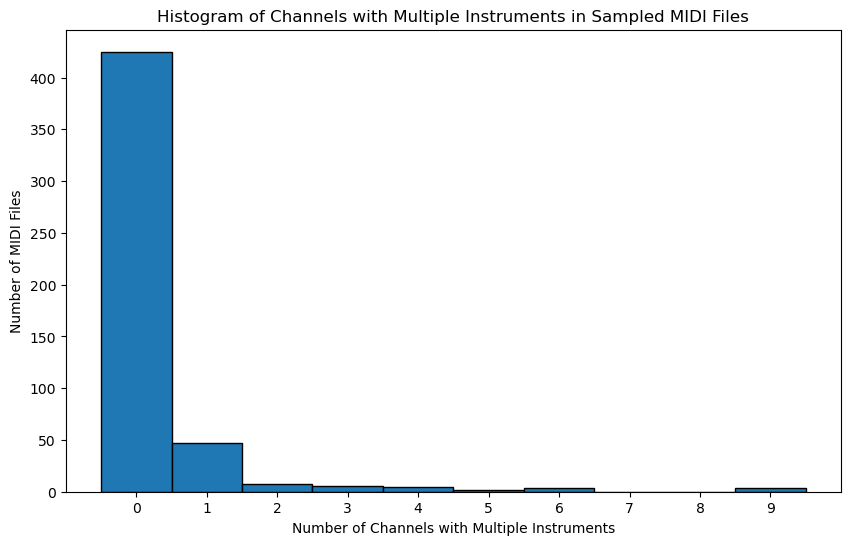

In [8]:
import os
import glob
import random
import mido
import matplotlib.pyplot as plt

# Directory containing cleaned MIDI files.
midi_dir = "datasets/raw_midi/lmd_clean_1track/train"

# Get all MIDI file paths in the directory.
all_midi_files = glob.glob(os.path.join(midi_dir, "*.mid"))
print(f"Found {len(all_midi_files)} MIDI files in '{midi_dir}'.")

# Sample n=500 files (or all files if fewer than 500)
n = 500
sample_files = random.sample(all_midi_files, min(n, len(all_midi_files)))
print(f"Sampling {len(sample_files)} MIDI files.")

# Count the number of channels with more than one instrument for each MIDI file.
channels_with_multiple_instruments = []
for file_path in sample_files:
    try:
        midi = mido.MidiFile(file_path)
        channel_instruments = {}
        
        for track in midi.tracks:
            for msg in track:
                if msg.type == 'program_change':
                    if msg.channel not in channel_instruments:
                        channel_instruments[msg.channel] = set()
                    channel_instruments[msg.channel].add(msg.program)
        
        # Count channels that have more than one instrument
        count = sum(1 for instruments in channel_instruments.values() if len(instruments) > 1)
        channels_with_multiple_instruments.append(count)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Create a histogram.
if channels_with_multiple_instruments:
    plt.figure(figsize=(10, 6))
    bins = range(min(channels_with_multiple_instruments), max(channels_with_multiple_instruments) + 2)
    plt.hist(channels_with_multiple_instruments, bins=bins, align='left', edgecolor='black')
    plt.xlabel("Number of Channels with Multiple Instruments")
    plt.ylabel("Number of MIDI Files")
    plt.title("Histogram of Channels with Multiple Instruments in Sampled MIDI Files")
    plt.xticks(range(min(channels_with_multiple_instruments), max(channels_with_multiple_instruments) + 1))
    plt.show()
else:
    print("No data available to plot.")


In [17]:
import os

# Directories for the splits
train_dir = "datasets/raw_midi/lmd_clean_1track/train"
val_dir = "datasets/raw_midi/lmd_clean_1track/val"
test_dir = "datasets/raw_midi/lmd_clean_1track/test"

# Get file lists for each split
train_files = os.listdir(train_dir)
val_files = os.listdir(val_dir)
test_files = os.listdir(test_dir)

# Convert to sets for uniqueness testing
train_set = set(train_files)
val_set = set(val_files)
test_set = set(test_files)

# Print the number of files in each split
print(f"Train set contains: {len(train_files)} files")
print(f"Validation set contains: {len(val_files)} files")
print(f"Test set contains: {len(test_files)} files")

# Check for uniqueness within each split
assert len(train_files) == len(train_set), "There are duplicate files in the train split!"
assert len(val_files) == len(val_set), "There are duplicate files in the validation split!"
assert len(test_files) == len(test_set), "There are duplicate files in the test split!"

# Check for uniqueness across splits (no file should appear in more than one split)
intersection_train_val = train_set.intersection(val_set)
intersection_train_test = train_set.intersection(test_set)
intersection_val_test = val_set.intersection(test_set)

print("\nIntersections:")
print(f"Train ∩ Validation: {intersection_train_val}")
print(f"Train ∩ Test: {intersection_train_test}")
print(f"Validation ∩ Test: {intersection_val_test}")

assert not intersection_train_val, "Some files are present in both train and validation splits!"
assert not intersection_train_test, "Some files are present in both train and test splits!"
assert not intersection_val_test, "Some files are present in both validation and test splits!"

print("\n✅ All splits are correct and all files are unique!")


Train set contains: 8000 files
Validation set contains: 1000 files
Test set contains: 1000 files

Intersections:
Train ∩ Validation: set()
Train ∩ Test: set()
Validation ∩ Test: set()

✅ All splits are correct and all files are unique!


In [29]:
import os
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paths
TRAIN_DATA_PATH = "datasets/tokenized/train"
VOCAB_PATH = "datasets/vocab/basic_vocab.json"

# Load vocabulary
with open(VOCAB_PATH, "r") as f:
    vocab = json.load(f)

# Reverse vocab (ID -> Token)
id_to_token = {v: k for k, v in vocab.items()}

# Load tokenized sequences
def load_all_sequences(data_path, max_files=1000):
    """Loads all tokenized sequences from the specified dataset path."""
    sequences = []
    files = sorted(os.listdir(data_path))[:max_files]  # Limit for performance
    for file in files:
        if file.endswith(".pkl"):
            with open(os.path.join(data_path, file), "rb") as f:
                seq = pickle.load(f)
                if len(seq) == 0:
                    print(file)
                sequences.append(seq)
    return sequences

train_sequences = load_all_sequences(TRAIN_DATA_PATH)
print(f"Loaded {len(train_sequences)} tokenized sequences from {TRAIN_DATA_PATH}")


Loaded 1000 tokenized sequences from datasets/tokenized/train


Min Length: 2
Max Length: 90954
Mean Length: 22106.94
Median Length: 21063.0
Number of zero lenght sequences: 0


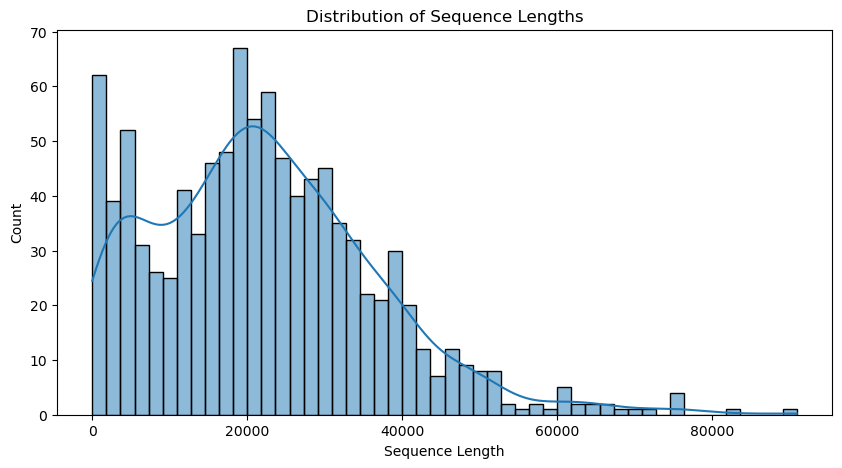

In [30]:
seq_lengths = []
num_zero_len = 0
for seq in train_sequences:
    seq_lengths.append(len(seq))
    if len(seq) == 0:
        num_zero_len += 1

# Statistics
print(f"Min Length: {np.min(seq_lengths)}")
print(f"Max Length: {np.max(seq_lengths)}")
print(f"Mean Length: {np.mean(seq_lengths):.2f}")
print(f"Median Length: {np.median(seq_lengths)}")
print(f"Number of zero lenght sequences: {num_zero_len}")

# Histogram of sequence lengths
plt.figure(figsize=(10, 5))
sns.histplot(seq_lengths, bins=50, kde=True)
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.title("Distribution of Sequence Lengths")
plt.show()


Top 20 Most Frequent Tokens:
TIME_SHIFT_10ms: 6061010
TIME_SHIFT_20ms: 480392
VELOCITY_25: 396520
TIME_SHIFT_30ms: 363711
NOTE_OFF_42: 362358
NOTE_ON_42: 362283
VELOCITY_32: 310463
VELOCITY_24: 285471
VELOCITY_20: 283575
VELOCITY_23: 277132
VELOCITY_21: 230245
TIME_SHIFT_40ms: 228021
VELOCITY_18: 223603
VELOCITY_22: 220974
VELOCITY_28: 218392
VELOCITY_26: 209527
VELOCITY_19: 208379
VELOCITY_16: 204812
TIME_SHIFT_50ms: 202222
NOTE_OFF_62: 192848


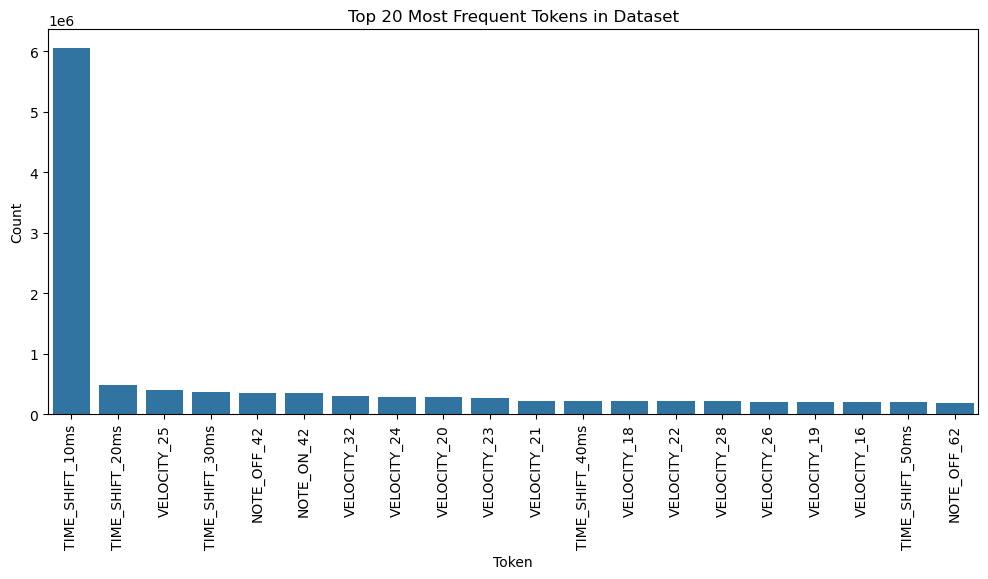

In [31]:
from collections import Counter

# Flatten sequences into a single list of token IDs
all_tokens = [token for seq in train_sequences for token in seq]

# Count token occurrences
token_counts = Counter(all_tokens)

# Convert to token names
token_names = {id_to_token[k]: v for k, v in token_counts.items()}
sorted_tokens = sorted(token_names.items(), key=lambda x: x[1], reverse=True)

# Display top 20 tokens
print("Top 20 Most Frequent Tokens:")
for token, count in sorted_tokens[:20]:
    print(f"{token}: {count}")

# Bar plot of most common tokens
plt.figure(figsize=(12, 5))
sns.barplot(x=[t[0] for t in sorted_tokens[:20]], y=[t[1] for t in sorted_tokens[:20]])
plt.xticks(rotation=90)
plt.xlabel("Token")
plt.ylabel("Count")
plt.title("Top 20 Most Frequent Tokens in Dataset")
plt.show()


Top 15 Most Frequent TIME_SHIFT Tokens:
TIME_SHIFT_10ms: 6061010
TIME_SHIFT_20ms: 480392
TIME_SHIFT_30ms: 363711
TIME_SHIFT_40ms: 228021
TIME_SHIFT_50ms: 202222
TIME_SHIFT_60ms: 165345
TIME_SHIFT_80ms: 108196
TIME_SHIFT_70ms: 101275
TIME_SHIFT_100ms: 83562
TIME_SHIFT_90ms: 76524
TIME_SHIFT_110ms: 66459
TIME_SHIFT_120ms: 51172
TIME_SHIFT_130ms: 45840
TIME_SHIFT_140ms: 30604
TIME_SHIFT_150ms: 30038


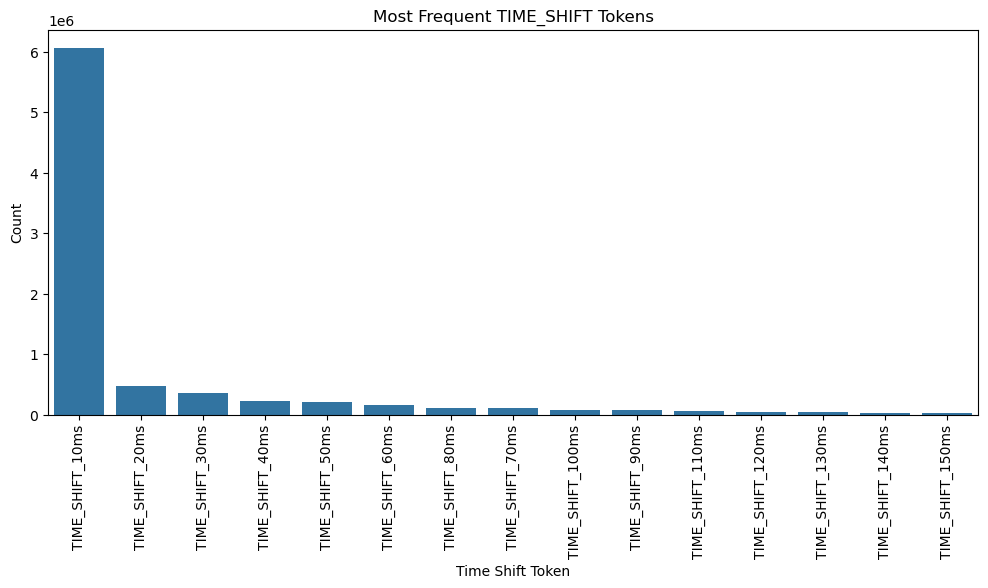

In [32]:
# Extract all TIME_SHIFT tokens
time_shift_tokens = [id_to_token[token] for token in all_tokens if "TIME_SHIFT" in id_to_token[token]]

# Count occurrences of each TIME_SHIFT value
time_shift_counts = Counter(time_shift_tokens)
sorted_shifts = sorted(time_shift_counts.items(), key=lambda x: x[1], reverse=True)

# Display top 15 time shifts
print("Top 15 Most Frequent TIME_SHIFT Tokens:")
for shift, count in sorted_shifts[:15]:
    print(f"{shift}: {count}")

# Plot distribution of TIME_SHIFT tokens
plt.figure(figsize=(12, 5))
sns.barplot(x=[t[0] for t in sorted_shifts[:15]], y=[t[1] for t in sorted_shifts[:15]])
plt.xticks(rotation=90)
plt.xlabel("Time Shift Token")
plt.ylabel("Count")
plt.title("Most Frequent TIME_SHIFT Tokens")
plt.show()


Top 10 Most Frequent VELOCITY Tokens:
VELOCITY_25: 396520
VELOCITY_32: 310463
VELOCITY_24: 285471
VELOCITY_20: 283575
VELOCITY_23: 277132
VELOCITY_21: 230245
VELOCITY_18: 223603
VELOCITY_22: 220974
VELOCITY_28: 218392
VELOCITY_26: 209527


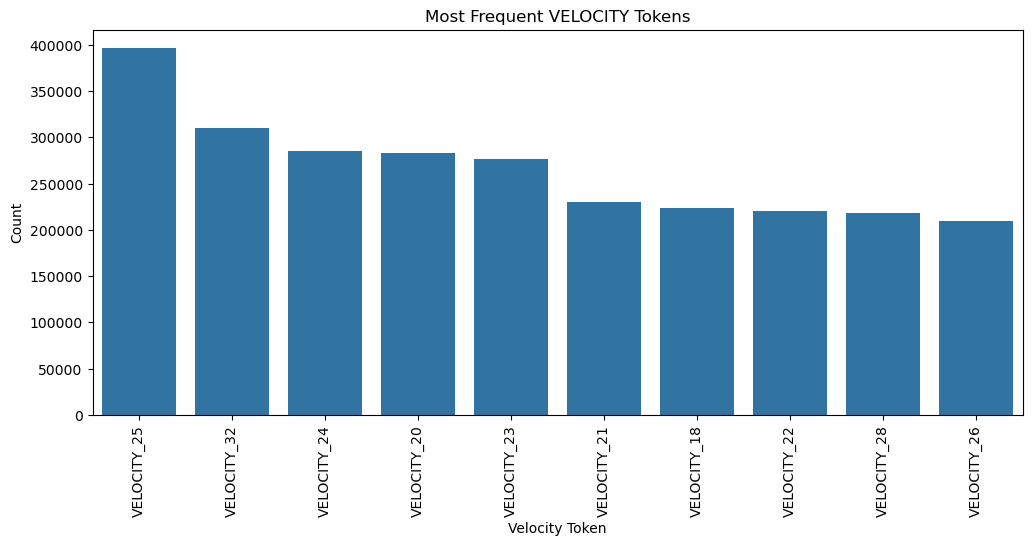

In [33]:
# Extract all VELOCITY tokens
velocity_tokens = [id_to_token[token] for token in all_tokens if "VELOCITY" in id_to_token[token]]

# Count occurrences
velocity_counts = Counter(velocity_tokens)
sorted_velocities = sorted(velocity_counts.items(), key=lambda x: x[1], reverse=True)

# Display top 10 velocities
print("Top 10 Most Frequent VELOCITY Tokens:")
for vel, count in sorted_velocities[:10]:
    print(f"{vel}: {count}")

# Plot velocity distribution
plt.figure(figsize=(12, 5))
sns.barplot(x=[t[0] for t in sorted_velocities[:10]], y=[t[1] for t in sorted_velocities[:10]])
plt.xticks(rotation=90)
plt.xlabel("Velocity Token")
plt.ylabel("Count")
plt.title("Most Frequent VELOCITY Tokens")
plt.show()
